# Stock Forecasting using ML

For this project I will train a machine learning model, more especifically a gradient boosting model, to predict the performance of stocks. The data will be collected using the yfinance library.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
plt.style.use('fivethirtyeight')

## Loading Data and Understanding Dataset

In [ ]:
nflx_df = yf.download('NFLX', start='2005-01-01', end='2024-1-1', progress=False)

In [ ]:
nflx_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.800000,1.800000,1.645714,1.702857,1.702857,11334400
2005-01-04,1.702857,1.707143,1.607143,1.665714,1.665714,17352300
2005-01-05,1.677143,1.677143,1.584286,1.600000,1.600000,12732300
2005-01-06,1.600000,1.624286,1.572857,1.578571,1.578571,8273300
2005-01-07,1.587143,1.650000,1.571429,1.588571,1.588571,7490700


In [ ]:
print(f'Dataframe contains {nflx_df.shape[0]} rows and {nflx_df.shape[1]} columns')
print('\nLet us check for missing values:')
nflx_df.isnull().sum().sum()

Dataframe contains 4781 rows and 6 columns

Let us check for missing values:


0

In [ ]:
# some summary statistics
nflx_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,150.285681,152.604171,147.894085,150.308280,150.308280,1.577663e+07
std,178.054246,180.585164,175.370681,178.011041,178.011041,1.816095e+07
min,1.300000,1.317143,1.272857,1.290000,1.290000,1.144000e+06
25%,6.707143,6.841429,6.597143,6.707143,6.707143,5.974500e+06
50%,56.175713,57.495712,55.357143,56.972858,56.972858,9.807900e+06
75%,297.899994,301.799988,291.690002,297.570007,297.570007,1.864310e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.155418e+08


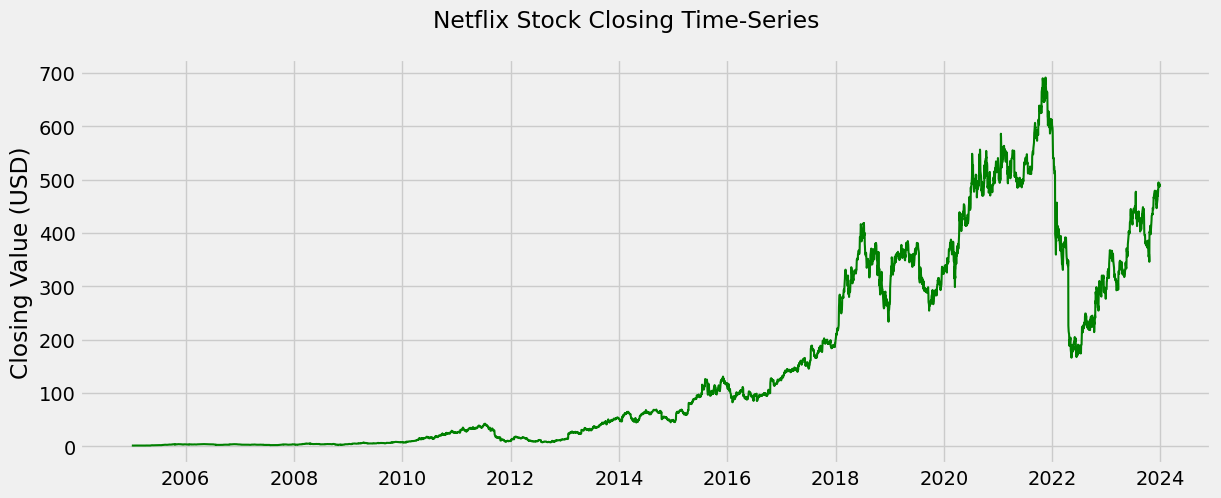

In [ ]:
fig = plt.figure(figsize=(13,5))
plt.plot(nflx_df.index, nflx_df.Close, color='green', linewidth=1.5)
plt.ylabel('Closing Value (USD)')
plt.suptitle('Netflix Stock Closing Time-Series')

plt.show()

## Feature Engineering



In [ ]:
# Our model will use data from previous days as features to predict the Closing value for the current day

# Let's define a function to create the dataframe we will need to train the model
def create_model_df(stock_df, days):
  df = stock_df[['Close']].copy()

  for i in range(1, days+1):
    df[f'Close_t-{i}'] = df.Close.shift(i)

  df['moving_avg'] = df.Close.shift(1).rolling(days).mean()
  df['moving_std'] = df.Close.shift(1).rolling(days).std()

  #df.bfill(inplace=True)

  # Another option: Since the Close column is getting shifted downwards, the first days rows will have null values
  # Rather than filling in the missing data with values that may affect the model's performance,
  # I can drop the rows since it is just a couple of rows in comparison with our data size
  #df.dropna
  return df.dropna(axis=0)

In [ ]:
df = create_model_df(nflx_df, 7)

In [ ]:
df.head(10)

,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5,Close_t-6,Close_t-7,moving_avg,moving_std
Date,,,,,,,,,,
2005-01-12,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.665714,1.702857,1.616939,0.048847
2005-01-13,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.665714,1.593061,0.039876
2005-01-14,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.576735,0.026234
2005-01-18,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.579388,0.029691
2005-01-19,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.584490,0.032466
2005-01-20,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.583469,0.032428
2005-01-21,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.579796,0.030309
2005-01-24,1.591429,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.580408,0.030189
2005-01-25,1.618571,1.591429,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.588368,0.022908


## Training Models

#### Baseline Model: Linear Regression

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor


X = df[['Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5', 'Close_t-6', 'Close_t-7', 'moving_avg', 'moving_std']]
y = df['Close']

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

regressor = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.1,  #0.001, 0.0001
    n_estimators=250,  #1000, 200
    max_depth=6,
    verbose=1

)

for train_index, test_index in cv.split(df):
    # Extract the train and test sets based on the split indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=predictions)
    mae = mean_absolute_error(y_true=y_test, y_pred=predictions)

    print(f"\nMSE: {mse} \nMAE: {mae}")
    print("-" * 30)

      Iter       Train Loss   Remaining Time 
         1           0.4989            4.15s
         2           0.4053            4.19s
         3           0.3295            4.58s
         4           0.2681            4.52s
         5           0.2182            4.38s
         6           0.1777            4.68s
         7           0.1450            4.76s
         8           0.1183            5.05s
         9           0.0968            4.75s
        10           0.0792            4.96s
        20           0.0126            3.38s
        30           0.0036            2.65s
        40           0.0020            2.24s
        50           0.0014            2.00s
        60           0.0011            1.79s
        70           0.0008            1.63s
        80           0.0007            1.50s
        90           0.0006            1.37s
       100           0.0004            1.26s
       200           0.0001            0.38s

MSE: 139.5100421054329 
MAE: 7.399448657510679
------

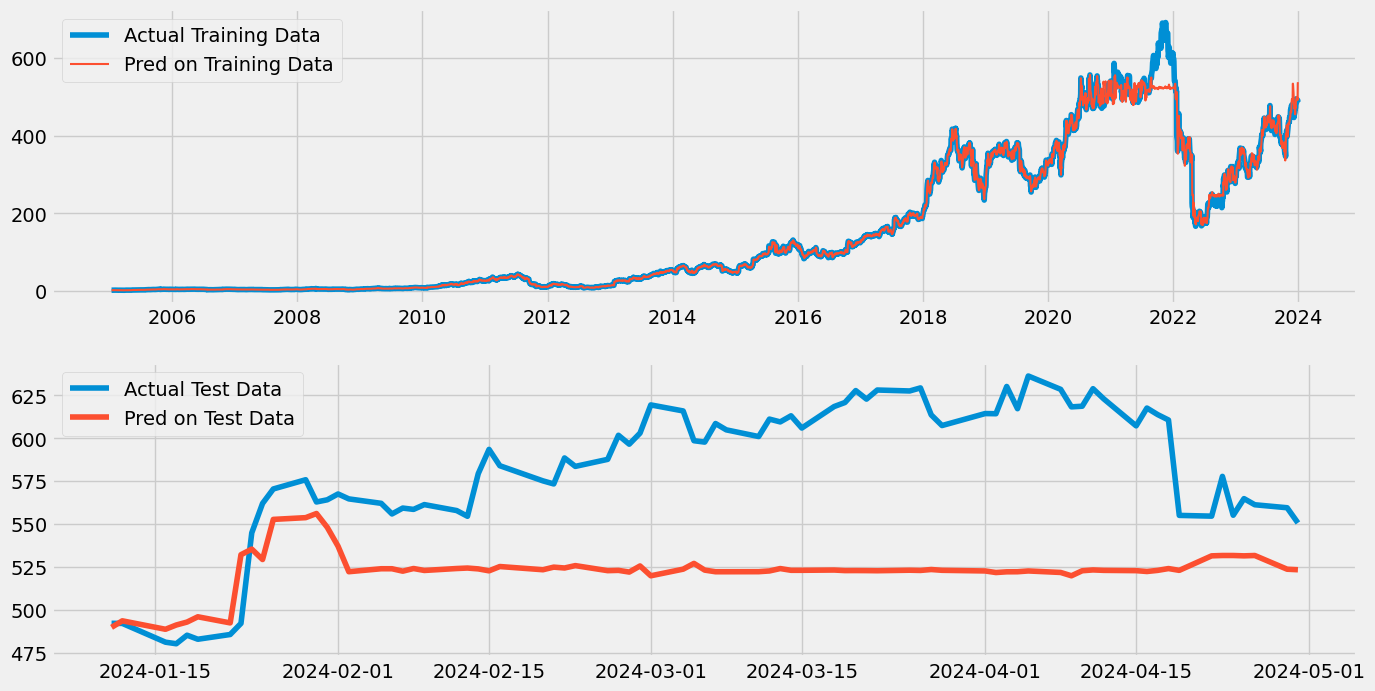

In [ ]:
## TEST with Netflix data

preds = regressor.predict(X)
netflix_unseen = yf.download('NFLX', start='2024-01-01', end='2024-5-1', progress=False)
netflix_unseen = create_model_df(netflix_unseen, days=7)
netflix_unseen = netflix_unseen[netflix_unseen.index > nflx_df.index.max()]

netflix_unseen_preds = regressor.predict(netflix_unseen.iloc[:, 1:])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

# this should do very well since it is the data it was trained on
ax1.plot(df.index, df.Close, label='Actual Training Data')
ax1.plot(df.index, preds, label='Pred on Training Data', linewidth = 1.5)

# unseen data, however there is very little unseen data since there is not much data from January
ax2.plot(netflix_unseen.index, netflix_unseen.Close, label= 'Actual Test Data')
ax2.plot(netflix_unseen.index, netflix_unseen_preds, label= 'Pred on Test Data')

ax1.legend()
ax2.legend()

plt.show()

## Testing with other companies

In [ ]:
def test_with_company(stock_symbol, regressor):
  df = yf.download(stock_symbol, start='2005-01-01', end='2024-1-5', progress=False) #2005-01-01 2023-11-01
  df = create_model_df(df, 7)
  preds = regressor.predict(df.iloc[:, 1:])

  print(f'MAE: {mean_absolute_error(df.Close, preds)} \nMSE: {mean_squared_error(df.Close, preds)} \n', '-' * 35)

  fig, ax = plt.subplots(figsize=(15,8))

  ax.plot(df.index, df.Close, label='Actual data')
  ax.plot(df.index, preds, label='Prediction', linewidth=1.5)
  ax.set_ylabel('Closing Price (USD)')
  ax.set_title(f'Predicting {stock_symbol.upper()} Stock')

  ax.legend()

  plt.show()

MAE: 5.558596336908289 
MSE: 66.33073378965413 
 -----------------------------------


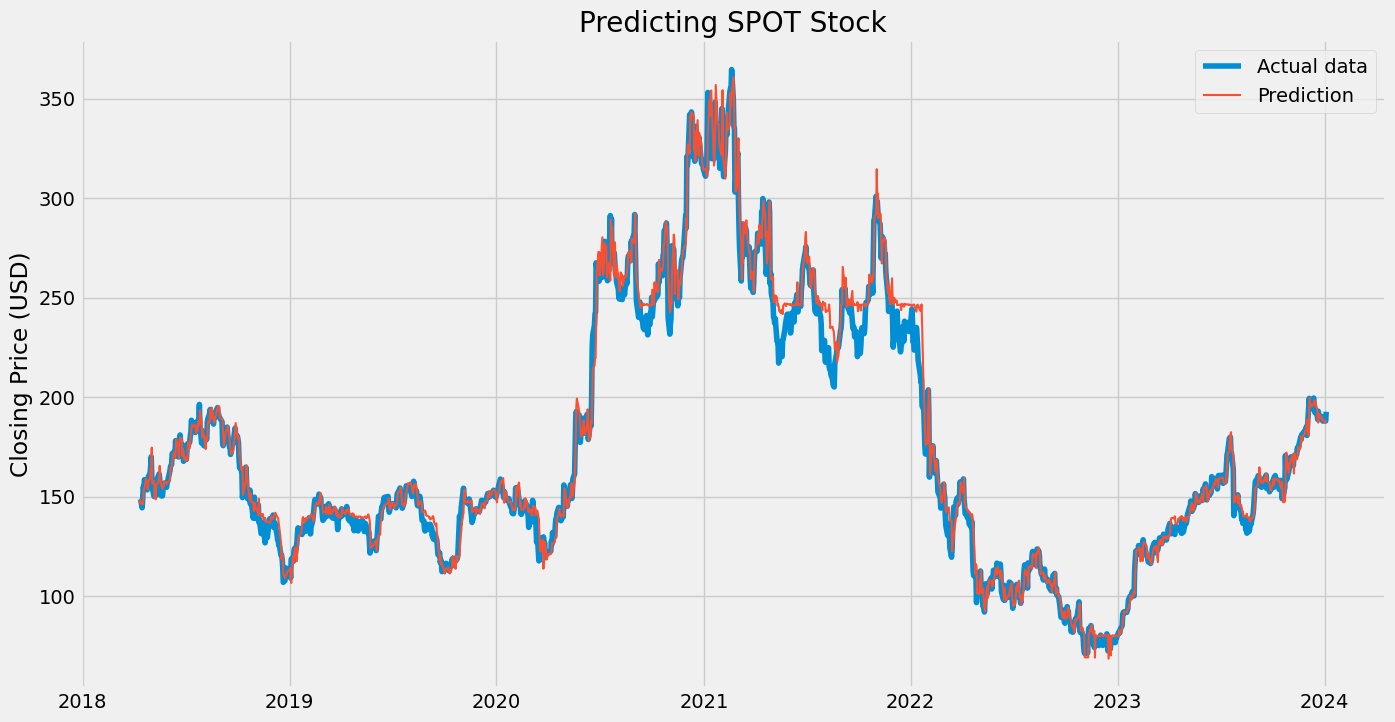

In [ ]:
test_with_company('SPOT', regressor)

MAE: 2.858061058538684 
MSE: 46.117639189509305 
 -----------------------------------


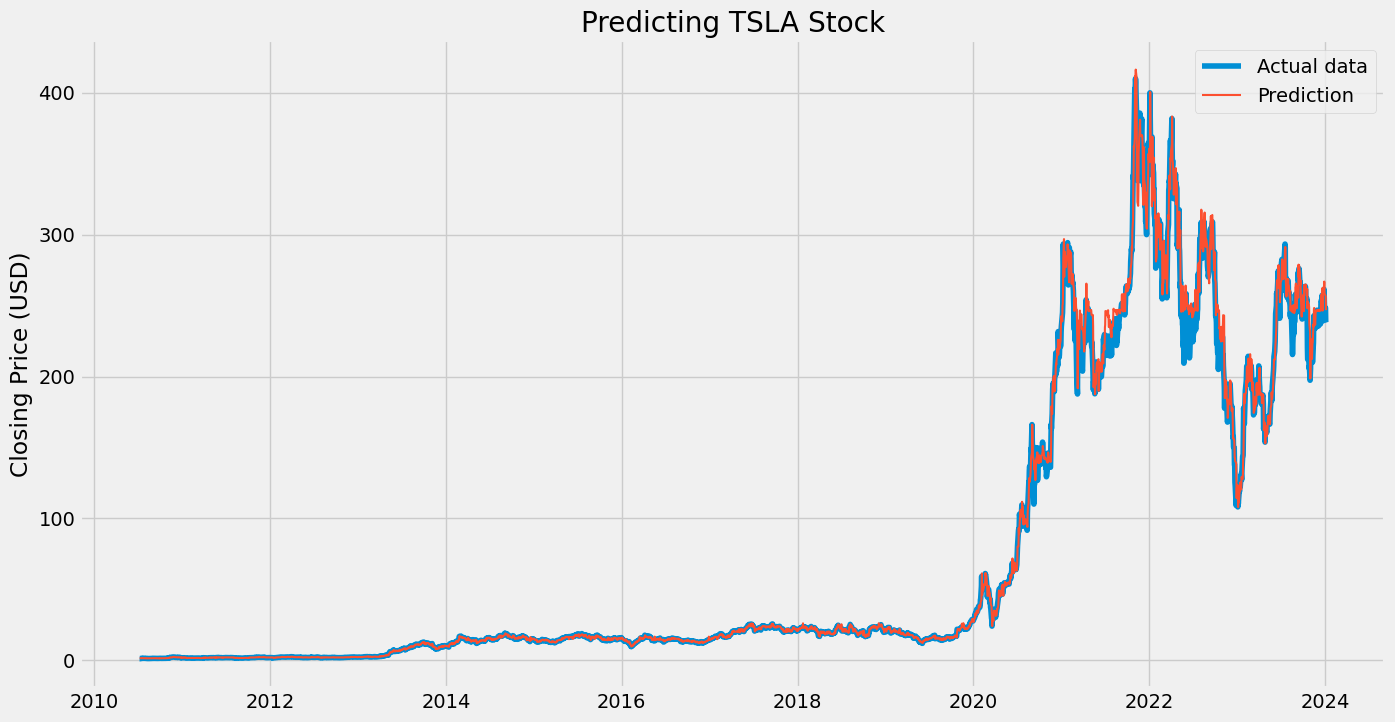

In [ ]:
test_with_company('TSLA', regressor)

MAE: 1.9600612342637436 
MSE: 16.828698180913353 
 -----------------------------------


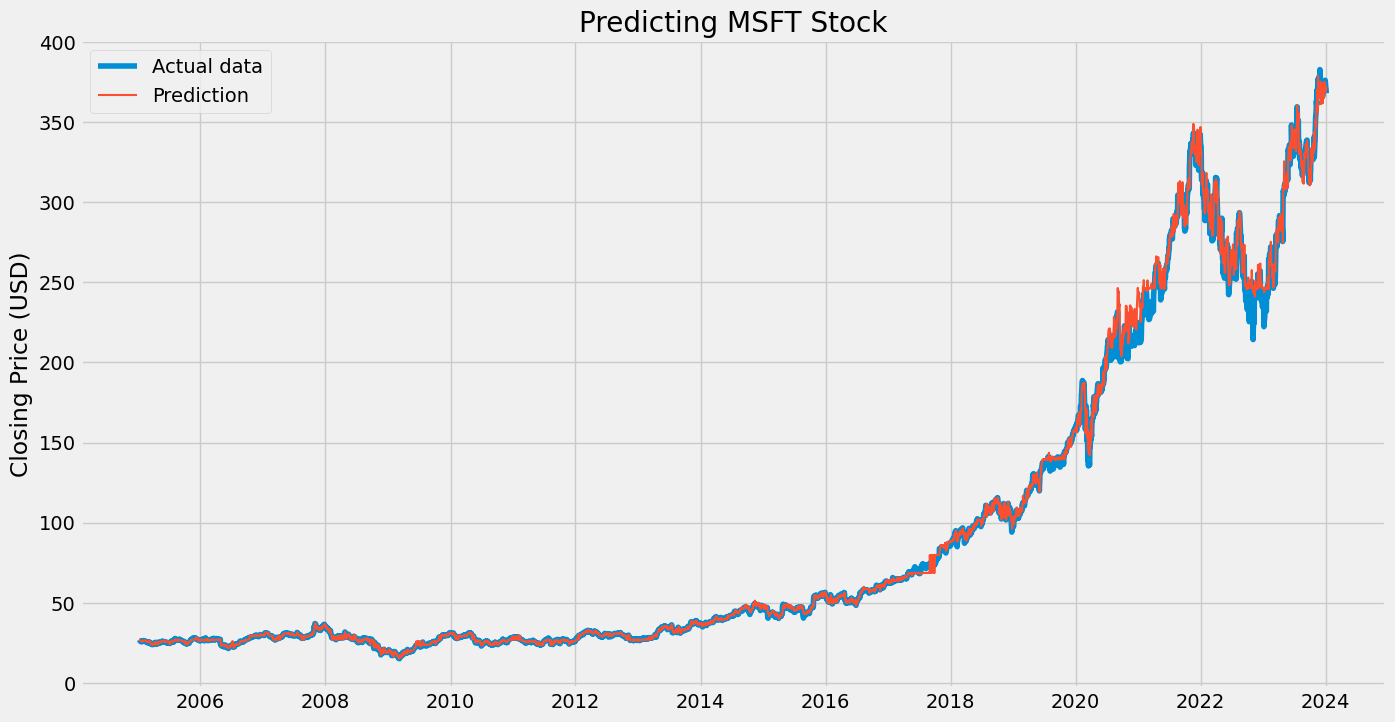

In [ ]:
test_with_company('MSFT', regressor)

MAE: 0.16622694330707155 
MSE: 0.06804867578284107 
 -----------------------------------


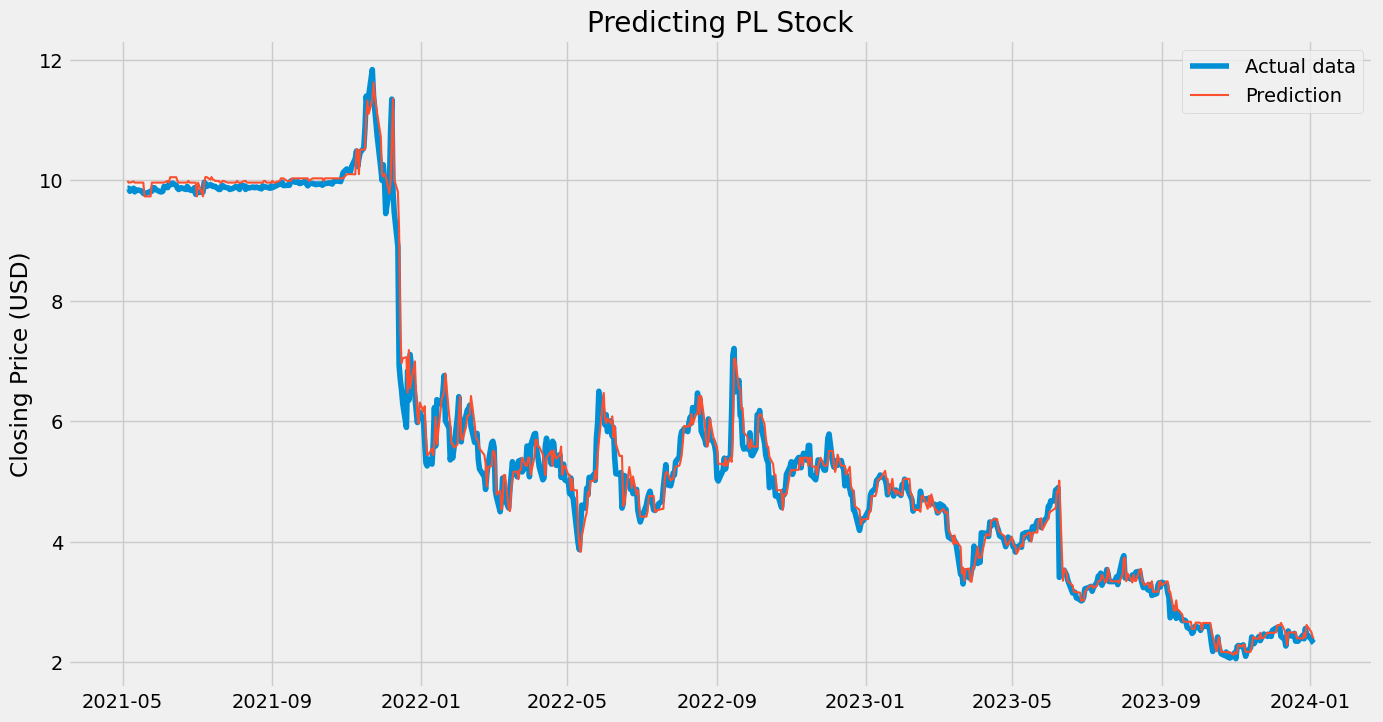

In [ ]:
test_with_company('PL', regressor)

MAE: 0.41501874455763016 
MSE: 2.5259118716411866 
 -----------------------------------


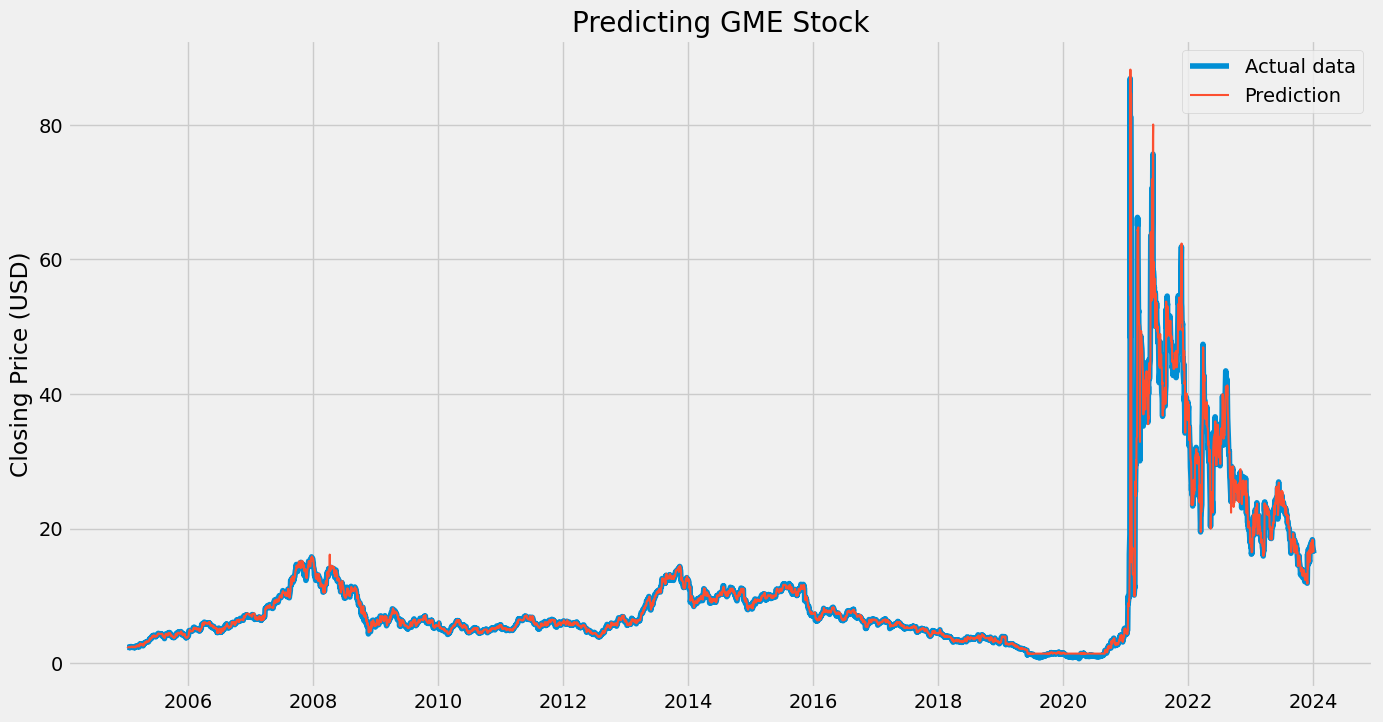

In [ ]:
test_with_company('gme', regressor)

MAE: 1487.3704555985948 
MSE: 4994955.059612161 
 -----------------------------------


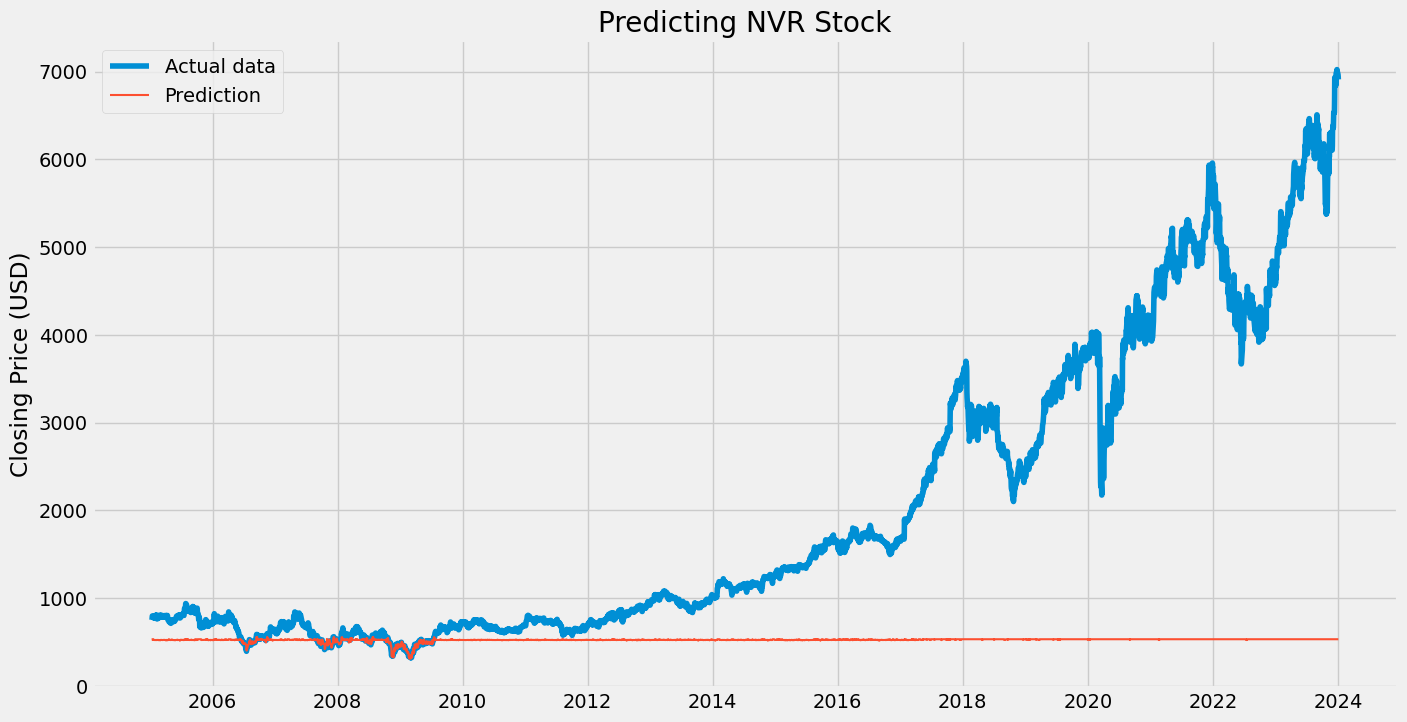

In [ ]:
test_with_company('nvr', regressor)

## Forecasting two decade's worth of data for a couple of stocks

In [ ]:
def forecast(stock_symbol, regressor):

  # query some baseline data in order to calculate lagged features, avg and std
  df = yf.download(stock_symbol, '2023-12-1', '2024-1-6', progress=False)
  df = create_model_df(df, 7)


  # define time interval for which we will forecast
  n_days = 60  # let's start out with two months for now

  # calculate features, then score, and repeat n_days times
  for day in range(n_days):
    date = df.iloc[-1].name + pd.Timedelta(days=1)

    if day == 0:
      first_day = date

    new_row = pd.DataFrame(columns=df.columns, index=[date])

    for i in range(7):
      new_row[f'Close_t-{i+1}'] = df.Close.shift(i).iloc[-1]

    new_row['moving_avg'] = new_row.iloc[-1, 1:-2].mean()
    new_row['moving_std'] = new_row.iloc[-1, 1:-2].std()

    new_row['Close'] = regressor.predict(new_row.iloc[:, 1:])

    df = pd.concat([df, new_row])

  # get forecasted data only
  df_forecasted = df[df.index >= first_day]

  fig, ax = plt.subplots(figsize=(15, 8))

  ax.plot(df_forecasted.index, df_forecasted.Close)

  ax.set_title(f'Forecasting for {stock_symbol.upper()} Stock')
  ax.set_ylabel('Closing Price (USD)')


  plt.show()

  # return df_forecasted

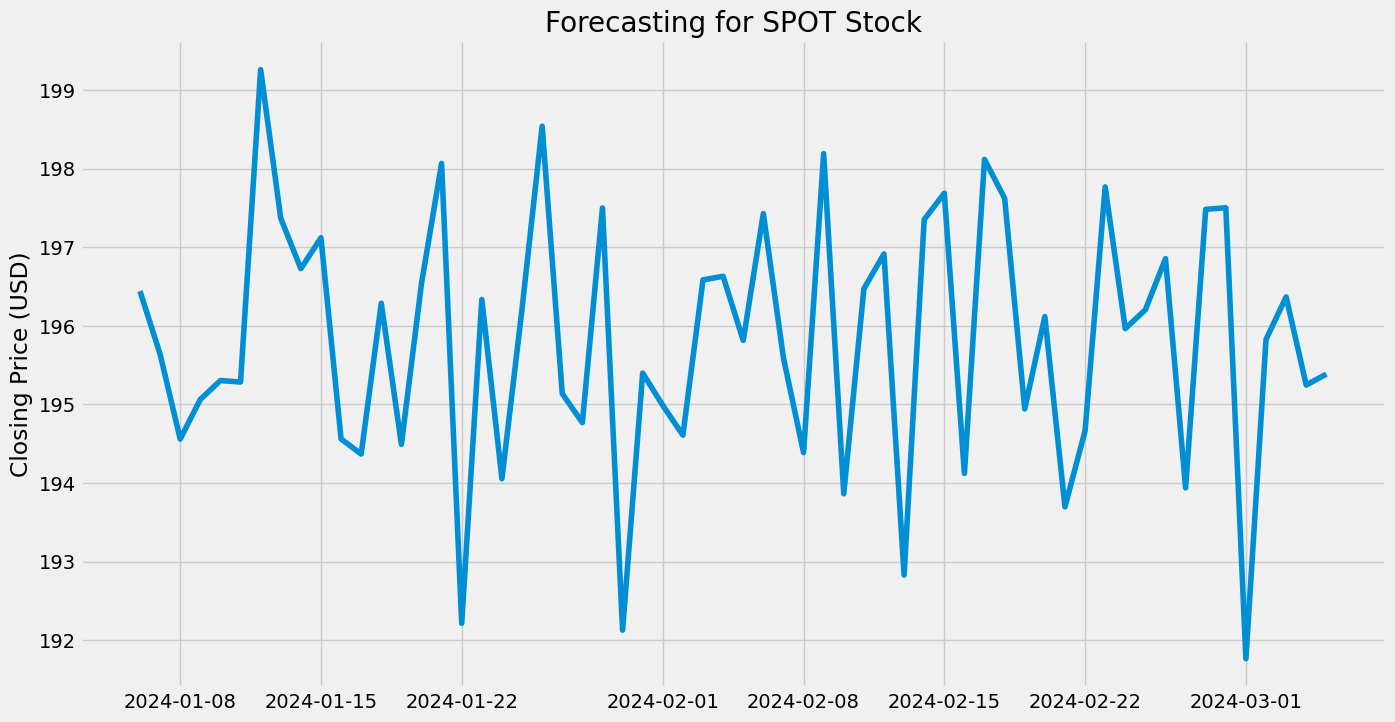

In [ ]:
forecast('SPOT', regressor)  # Spotify

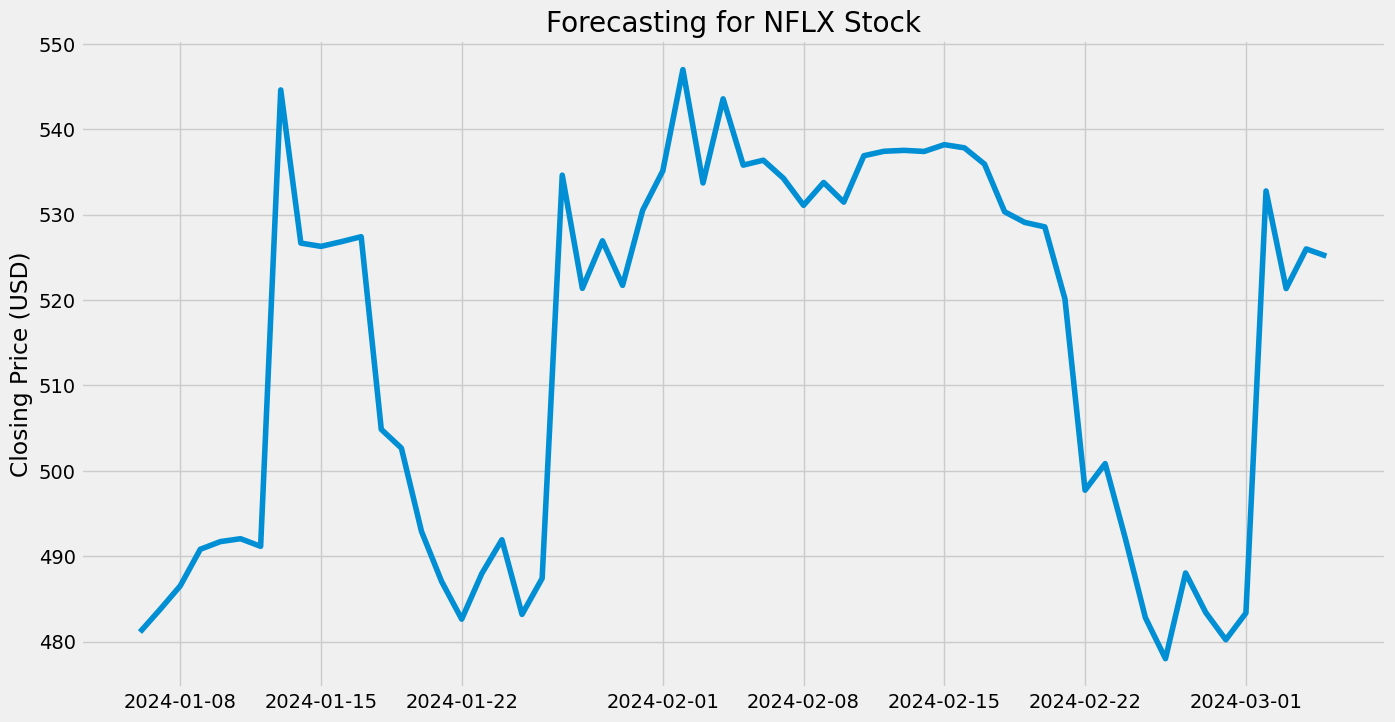

In [ ]:
forecast('NFLX', regressor)  # Netflix

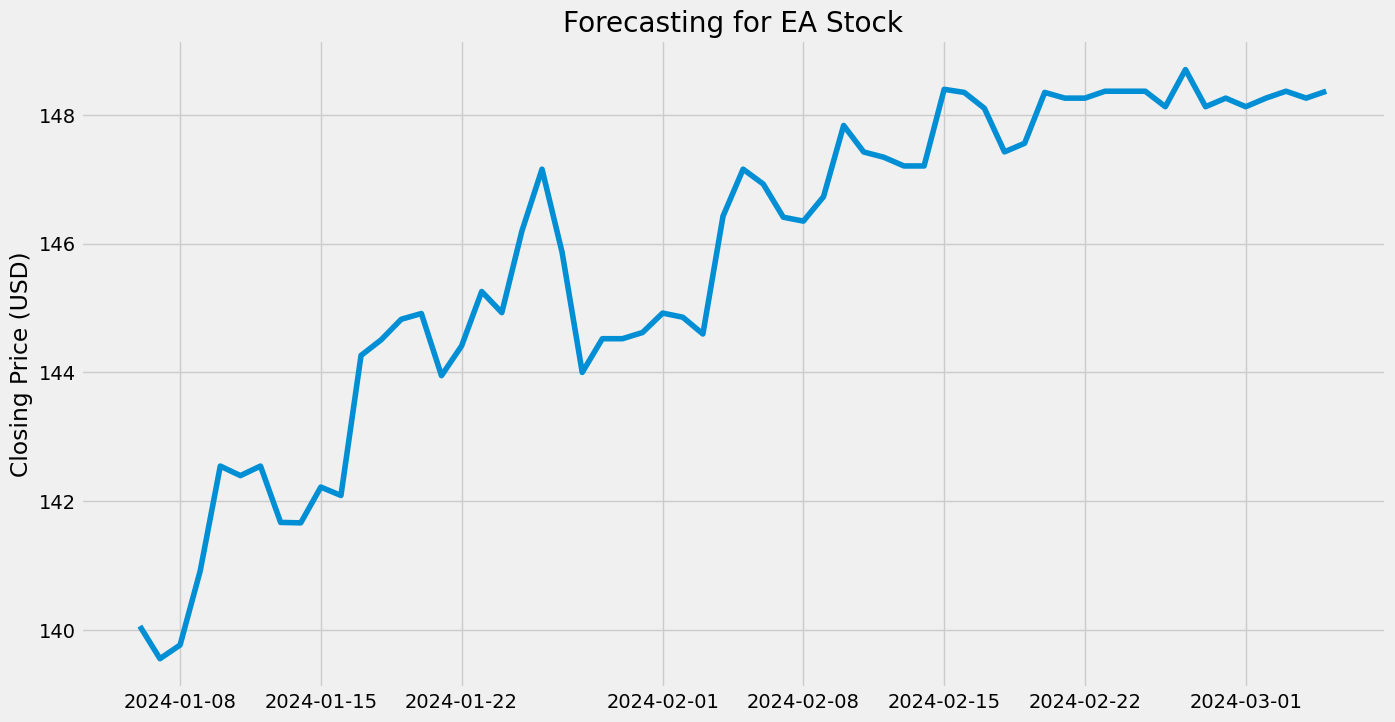

In [ ]:
forecast('ea', regressor)  # Electronic Arts

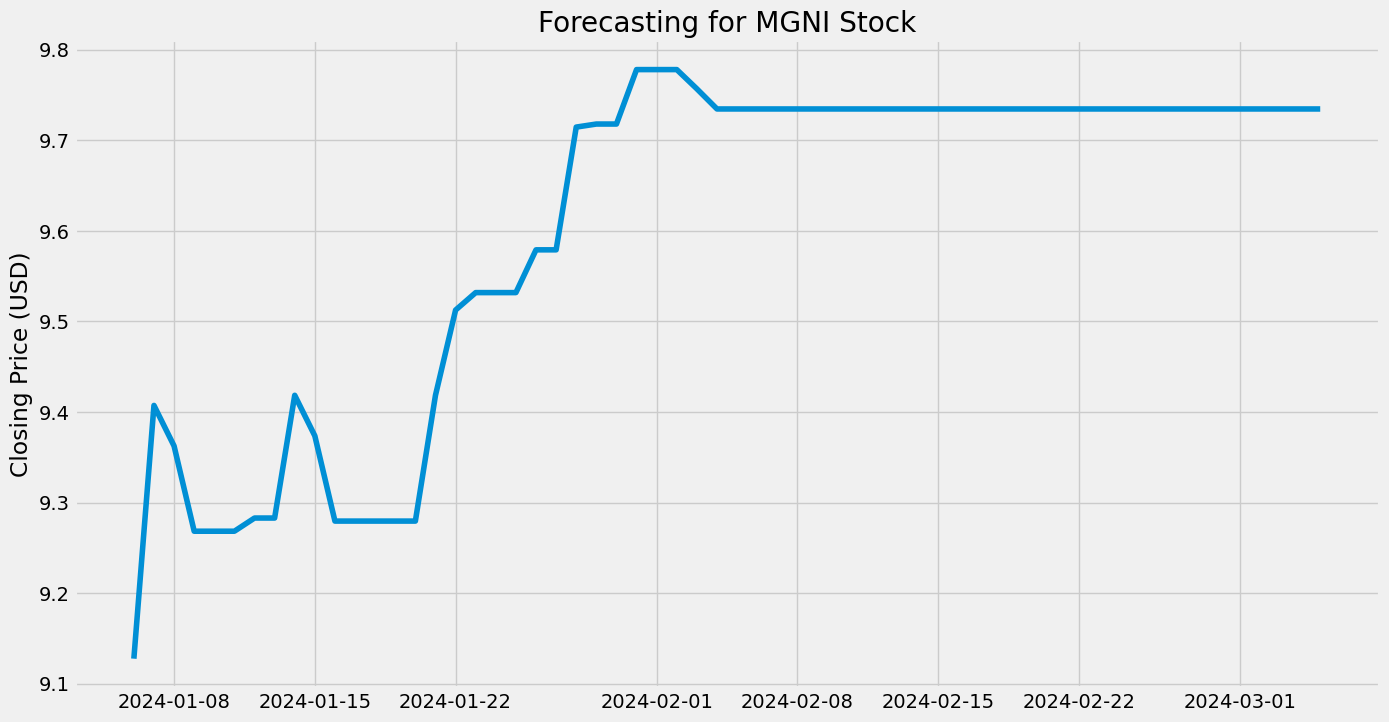

In [ ]:
forecast('mgni', regressor)  # Magnite Inc

## Training an LSTM model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# let's use a different stock with a wider range in closing prices to try to avoid a ceiling
nvr_df = yf.download('nvr', start='1995-01-01', end='2024-1-1', progress=False)

In [ ]:
# create training data, this time we will create more lagged features, looking back at 30 days
training_set = create_model_df(nvr_df, 30)

In [ ]:
training_set.head()

,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5,Close_t-6,Close_t-7,Close_t-8,Close_t-9,...,Close_t-23,Close_t-24,Close_t-25,Close_t-26,Close_t-27,Close_t-28,Close_t-29,Close_t-30,moving_avg,moving_std
Date,,,,,,,,,,,,,,,,,,,,,
1995-02-14,6.125,6.000,5.875,5.875,5.750,5.625,5.625,5.500,5.625,5.625,...,5.500,5.5,5.625,5.625,5.375,5.500,5.500,5.500,5.600000,0.132938
1995-02-15,6.250,6.125,6.000,5.875,5.875,5.750,5.625,5.625,5.500,5.625,...,5.500,5.5,5.500,5.625,5.625,5.375,5.500,5.500,5.620833,0.162428
1995-02-16,6.125,6.250,6.125,6.000,5.875,5.875,5.750,5.625,5.625,5.500,...,5.500,5.5,5.500,5.500,5.625,5.625,5.375,5.500,5.645833,0.197187
1995-02-17,6.125,6.125,6.250,6.125,6.000,5.875,5.875,5.750,5.625,5.625,...,5.500,5.5,5.500,5.500,5.500,5.625,5.625,5.375,5.666667,0.213583
1995-02-21,6.250,6.125,6.125,6.250,6.125,6.000,5.875,5.875,5.750,5.625,...,5.625,5.5,5.500,5.500,5.500,5.500,5.625,5.625,5.691667,0.221995


In [ ]:
# let's create our inputs and targets
Y = training_set.pop('Close').values
X = training_set.values

In [ ]:
tss = TimeSeriesSplit(n_splits=5)

history_list = []

for train_index, test_index in tss.split(X):
    # Extract the train and test sets based on the split indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # since we were using a gradient boosting ensemble model previously, scaling data did not matter as much
    # However, for an LSTM, scaling data is crucial
    scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1,1))

    # Reshape features
    X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
    X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

    model = tf.keras.models.Sequential([
        layers.LSTM(50, return_sequences=True, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])),
        layers.Dropout(0.5),
        layers.LSTM(25),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')


    history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=20, batch_size=32, shuffle=False, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    history_list.append(history)



Epoch 1/20
38/38 [==============================] - 8s 93ms/step - loss: 0.2095 - val_loss: 34.2177
Epoch 2/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1825 - val_loss: 32.7046
Epoch 3/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1592 - val_loss: 31.2667
Epoch 4/20
38/38 [==============================] - 0s 11ms/step - loss: 0.1342 - val_loss: 29.7574
Epoch 5/20
38/38 [==============================] - 0s 9ms/step - loss: 0.1091 - val_loss: 28.1066
Epoch 6/20
38/38 [==============================] - 0s 8ms/step - loss: 0.0821 - val_loss: 26.3508
Epoch 7/20
38/38 [==============================] - 0s 11ms/step - loss: 0.0552 - val_loss: 24.5498
Epoch 8/20
38/38 [==============================] - 0s 10ms/step - loss: 0.0349 - val_loss: 22.8080
Epoch 9/20
38/38 [==============================] - 0s 10ms/step - loss: 0.0242 - val_loss: 21.3616
Epoch 10/20
38/38 [==============================] - 0s 10ms/step - loss: 0.0159 - val_loss: 20.2705
E

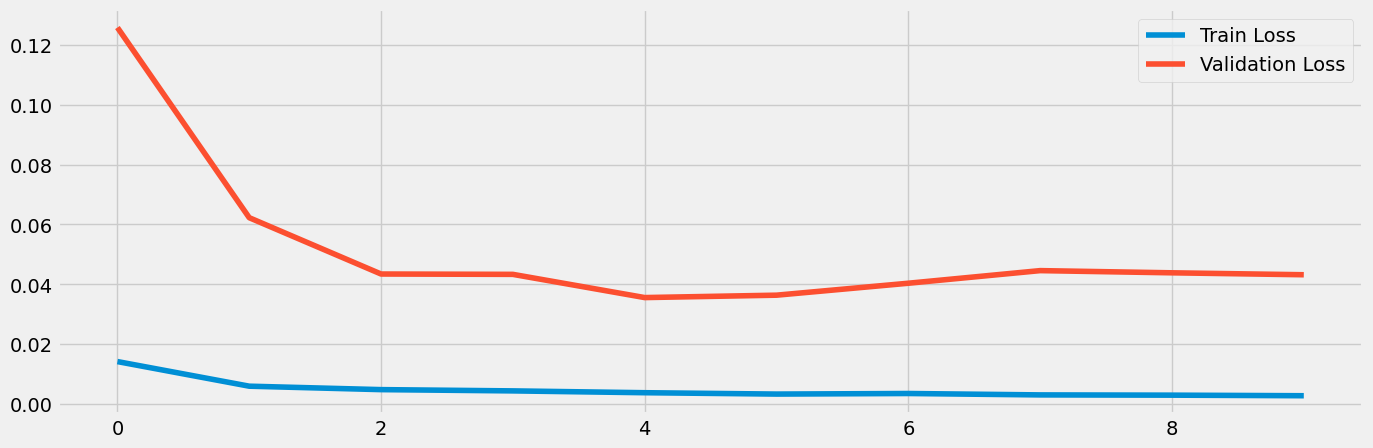

In [ ]:
fig, ax1= plt.subplots(1, 1, figsize=(15,5))

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')

ax1.legend()
plt.show()

## Testing LSTM Model

In [ ]:
nvr_df_test = yf.download('nvr', start='2024-01-01', end='2024-5-1', progress=False)

In [ ]:
test_set = create_model_df(nvr_df_test, 30)

In [ ]:
# let's create our inputs and targets
Y = test_set.pop('Close').values
X = test_set.values

In [ ]:
X = scaler.transform(X)
Y = target_scaler.transform(Y.reshape(-1,1))

# Reshape features
X = X.reshape(X.shape[0], 1, X.shape[1])

In [ ]:
model.evaluate(X, Y)

2/2 [==============================] - 0s 8ms/step - loss: 0.5364


0.5363637208938599

In [ ]:
predictions = model.predict(X)

2/2 [==============================] - 1s 7ms/step


In [ ]:
inversed_preds = target_scaler.inverse_transform(predictions)

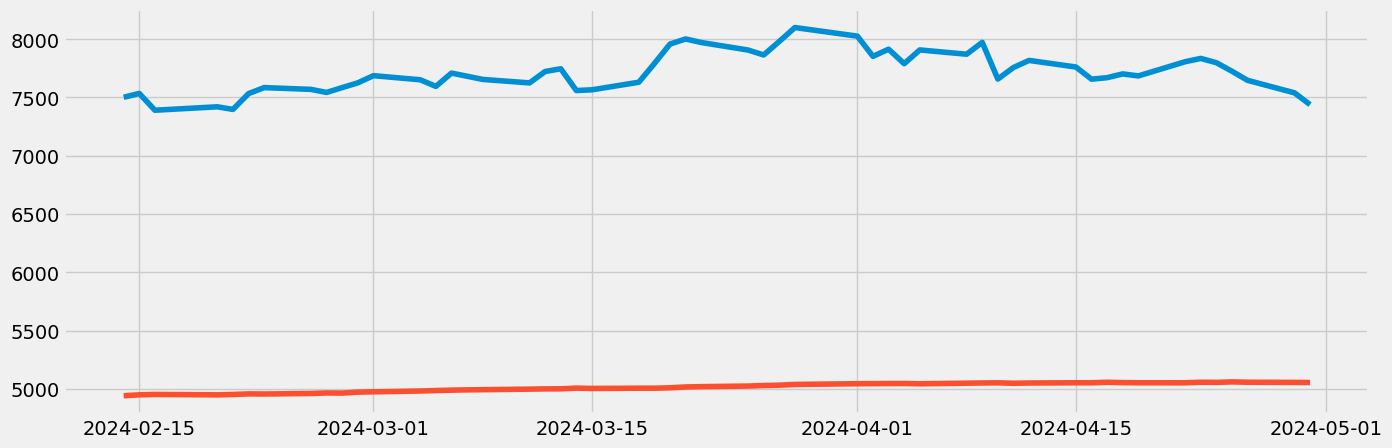

In [ ]:
fig, ax2= plt.subplots(1, 1, figsize=(15,5))

ax2.plot(nvr_df_test[nvr_df_test.index >= test_set.index.min()].index, nvr_df_test[nvr_df_test.index >= test_set.index.min()].Close, label= 'Actual Prices')
ax2.plot(test_set.index, inversed_preds, label= 'Pred on Test Data')

plt.show()

In [ ]:
def predict_with_LSTM(stock_symbol):
  df = yf.download(stock_symbol, start='2005-01-01', end='2024-1-5', progress=False) #2005-01-01 2023-11-01
  df = create_model_df(df, 30)

  close = df.Close

  Y = df.pop('Close').values
  X = df.values

  X = scaler.transform(X)
  Y = target_scaler.transform(Y.reshape(-1,1))

  # Reshape features
  X = X.reshape(X.shape[0], 1, X.shape[1])

  test_loss = model.evaluate(X, Y)

  predictions = model.predict(X)
  inversed_preds = target_scaler.inverse_transform(predictions)

  print(f"Loss - {test_loss}")

  fig, ax = plt.subplots(figsize=(15,8))

  ax.plot(df.index, close, label='Actual Prices')
  ax.plot(df.index, inversed_preds, label='Prediction', linewidth=1.5)
  ax.set_ylabel('Closing Price (USD)')
  ax.set_title(f'Predicting {stock_symbol.upper()} Stock')

  ax.legend()

  plt.show()

45/45 [==============================] - 0s 2ms/step
Loss - 0.00015468118363060057


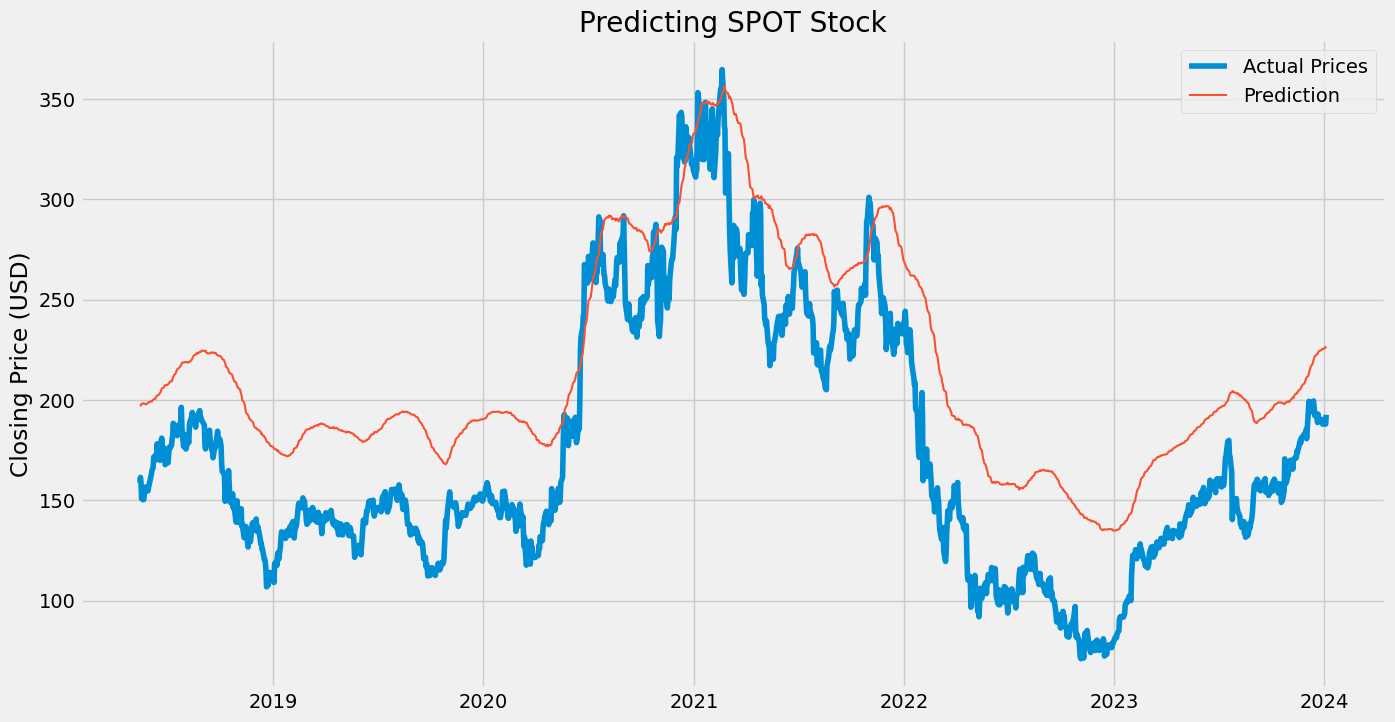

In [ ]:
predict_with_LSTM("spot")

149/149 [==============================] - 0s 3ms/step
Loss - 0.00025591402663849294


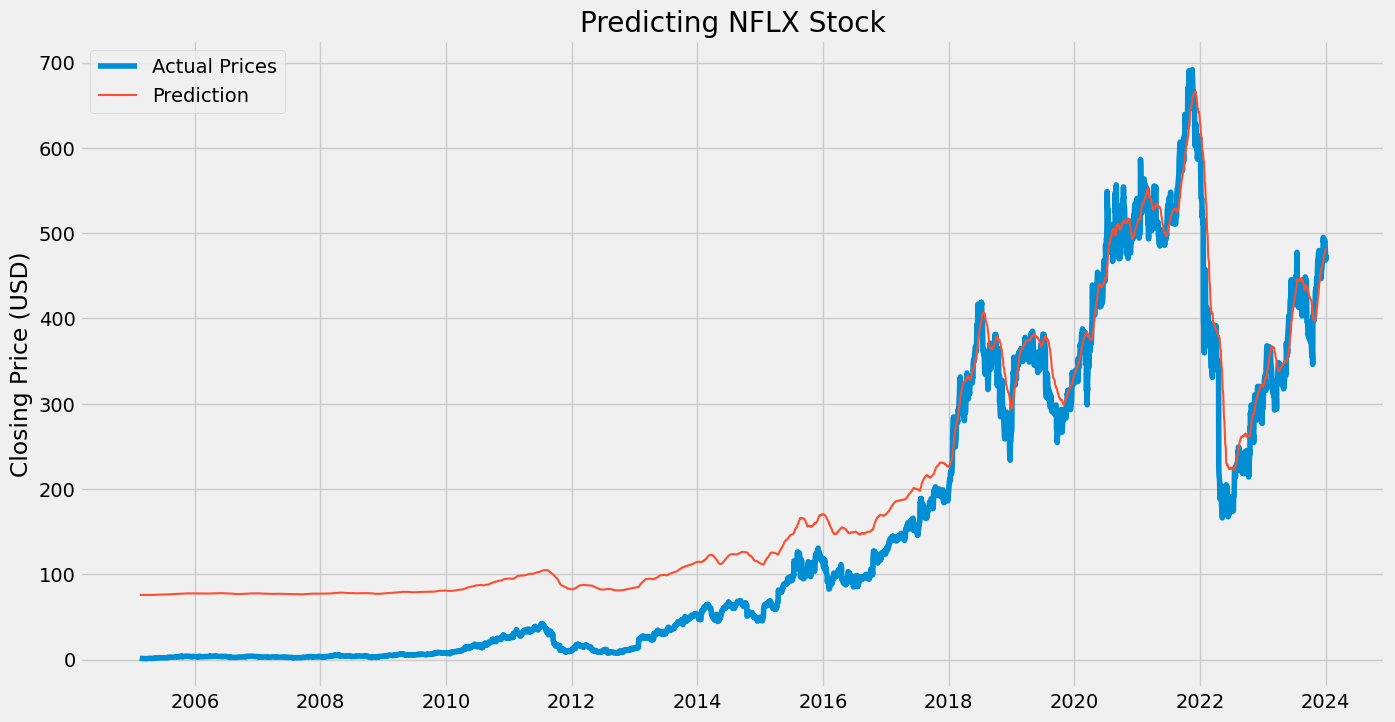

In [ ]:
predict_with_LSTM("nflx")

## Conclusion

Although the model performed well at predicting historical data for the most part, it seems like it has issues once the prices go above a certain threshold as can be seen in the NVR stock graph for example. This is definitely an area for future improvement. When it comes to forecasting, I tried forecasting for two months, but the forecasts were not accurate. Nonetheless, the results are better than I expected.

In addition, I wanted to get more familiar with training an LSTM model using TensorFlow, which I achieved. I tried to fix some of the shortcomings of the initial model by using a different stock with a wider range of closing prices to try and avoid the ceiling the initial model was encountering. However, it seems like the LSTM model is also suffering from it as can be seen for the test set prediction on NVR stock. However, it performed well on historical data once again.